# QWEN 4B fine-tuning on LogicInference_OA

## 🔧 Setup dell’Ambiente: Installazione Pacchetti. Import delle Librerie e Configurazione GPU

In [1]:
%%capture
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!pip install pip3-autoremove
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu124
!pip install unsloth
!pip install --upgrade transformers==4.52.4

In [2]:
import unsloth
from unsloth import is_bfloat16_supported
from unsloth import (
    FastLanguageModel 
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-14 10:09:51.847311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752487792.193956      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752487792.300146      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
import os
import gc
import random
import torch
import time
import json
import pandas as pd
import numpy as np
from IPython.display import Markdown
from datasets import load_dataset, Dataset, concatenate_datasets
from huggingface_hub import login
from transformers import TrainerCallback
from trl import SFTTrainer, SFTConfig

In [ ]:
import subprocess

token = ""
command = f"huggingface-cli login --token {token}"
subprocess.run(command, shell=True)

print("Login su HF fatto!")

Login su HF fatto!


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `login-token` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `login-token`


In [5]:
OUTPUT_DIR  = "/kaggle/working/output"
LOG_DIR     = "/kaggle/working/logs"
LOSS_DIR    = "/kaggle/working/loss"
DATASET     = "KK04/LogicInference_OA"

In [6]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(LOSS_DIR, exist_ok=True)

## 🛠️ Configurazione del Modello

### Variabili principali

In [7]:
MODEL_NAME  = "unsloth/Qwen3-4B-unsloth-bnb-4bit"

MAX_LENGTH  = 2048
N_QBITS     = 4
SEED        = 33

### Quantizzazione del Modello
La quantizzazione è una tecnica che permette di ridurre il peso e il consumo di memoria di un modello neurale, convertendo i suoi parametri da rappresentazioni ad alta precisione (tipicamente 32 bit) a versioni più compatte, come 8 bit o 4 bit.

Nel contesto di modelli di linguaggio di grandi dimensioni (LLM), questo è fondamentale per:

- Velocizzare l'inferenza e/o il fine-tuning
- Ridurre il consumo di memoria GPU (permette l'uso su hardware più limitato)
- Caricare modelli più grandi su dispositivi con risorse contenute


In questo blocco di codice, si decide se caricare il modello in 4 bit o 8 bit in base al valore della variabile N_QBITS. Questo consente di scegliere dinamicamente il livello di quantizzazione da usare, a seconda del contesto o delle risorse disponibili.

In [8]:
print(f"Quantizzazione del modello: {N_QBITS} bit")
load_in_4bit         = True if N_QBITS == 4 else False
load_in_8bit         = True if N_QBITS == 8 else False
print(f"Quantizzazione 4 bit modello:{load_in_4bit}")
print(f"Quantizzazione 8 bit modello:{load_in_8bit}")

Quantizzazione del modello: 4 bit
Quantizzazione 4 bit modello:True
Quantizzazione 8 bit modello:False


### Caricamento del modello e del tokenizzatore (usando unsloth)

In questo blocco di codice viene caricato il modello unsloth/Qwen3-4B-unsloth-bnb-4bit, una versione ottimizzata del modello linguistico Qwen3-4B, resa disponibile dalla libreria Unsloth.

Il modello è stato quantizzato a 4 bit utilizzando la libreria bitsandbytes, una tecnica che consente di ridurre drasticamente l’uso di memoria e velocizzare le operazioni, pur mantenendo una buona accuratezza. Questo è particolarmente utile quando si lavora con GPU con poca memoria, o quando si vuole eseguire fine-tuning in modo più leggero.

Viene utilizzato il metodo FastLanguageModel.from_pretrained, fornito da Unsloth, che permette di caricare sia il modello che il tokenizer associato, con supporto nativo alla quantizzazione e alla configurazione della lunghezza massima di input (max_seq_length).

In [9]:
print(f"Caricamento del modello e del tokenizer {MODEL_NAME}...")

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name           = MODEL_NAME,
    dtype                = None,
    max_seq_length       = MAX_LENGTH,
    load_in_4bit         = load_in_4bit,
)

Caricamento del modello e del tokenizer unsloth/Qwen3-4B-unsloth-bnb-4bit...
==((====))==  Unsloth 2025.7.3: Fast Qwen3 patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

### Setup per LoRA fine-tuning

Si vuole “incapsulare” il modello in una versione PEFT (Parameter‐Efficient Fine‐Tuning) tramite LoRA: questo permette di apprendere soltanto pochi parametri aggiuntivi (i “low-rank adapters”) anziché ri-allenare tutti i miliardi di pesi del modello.

LoRA è una tecnica che consente di aggiornare solo una piccola parte dei parametri del modello durante il fine-tuning, mantenendo fissi gli altri.
ùParametri principali:


1. Bisogna specificare il rank degli adattatori LoRA ossia il rango della decomposizione a bassa dimensione (più è basso, più è leggero il fine-tuning).


   $\rightarrow$ Ogni matrice di attenzione Q/K/V/O (o altri layer target) viene parametrizzata come somma della matrice pre-addestrata più un prodotto di due matrici di dimensione `(in_features × r)` e `(r × out_features)`.

3. Bisogna specificare i moduli del modello su cui applicare LoRA (proiezioni dell’attenzione e componenti del feed-forward). La lista **target_modules** corrisponde ai nomi dei layer (sub-moduli) su cui applicare LoRA.

4. Bisogna specificare lo **scaling factor** ossia il fattore di scala per controllare l’impatto delle modifiche apprese. In questo caso è pari a 32: i prodotti `A·B` (dove `A` e `B` sono le due matrici rank-ridotto) vengono moltiplicati per `alpha / r`.

5. Il **dropout** è nullo in modo che non venga applicato alle attivazioni all’interno del modulo LoRA

6. Per quanto riguarda i termini di bias nei layer originali non si aggiunge alcun bias trainabile: `"none"` è spesso più leggero e funziona bene se il modello principale mantiene i suoi bias congelati

#### Flusso complessivo

1. **Modello principale** congelato in quasi tutti i pesi.
2. **LoRA adapters** (due matrici rank-ridotto per layer) sono inizializzati casualmente.
3. Durante il fine-tuning si aggiornano solo questi adattatori (e, opzionalmente, qualche bias), mantenendo basso il numero di parametri addestrati.
4. **Gradient checkpointing** ti aiuta a rientrare in VRAM su contesti molto lunghi.

Questo setup permette di fare fine-tuning su Qwen-7B (o simili) anche con risorse limitate, mantenendo buone performance sia in generazione testo sia in capacità di reasoning. Se hai bisogno di esempi di training loop o di come salvare/ripristinare solo i pesi LoRA, dimmi pure!


In [10]:
model = FastLanguageModel.get_peft_model(
    model,
    r                          = 8,

    target_modules             = ["q_proj", "k_proj", "v_proj", "o_proj",
                                  "gate_proj", "up_proj", "down_proj"],

    #Permette di applicare LoRA solo a componenti specifiche del modello, ottimizzando il bilanciamento
    #tra efficienza computazionale e capacità di apprendimento
    #q_proj, k_proj, v_proj, o_proj: Parti delle proiezioni nella self-attention.
    #gate_proj, up_proj, down_proj: Componenti dei feed-forward layer

    lora_alpha                 = 16,
    lora_dropout               = 0, # 0 è ottimizzato
    bias                       = "none",

    use_gradient_checkpointing = "unsloth",
    random_state               = SEED,
    max_seq_length             = MAX_LENGTH,
    use_rslora                 = False,
    loftq_config               = None,
)

Unsloth 2025.7.3 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


### Check sul tokenizzatore

Il **tokenizer** è uno strumento fondamentale per poter utilizzare un modello di linguaggio (LLM) e serve a trasformare il testo in input (stringhe) in numeri (token) che il modello può capire e processare.

Allo stesso modo, dopo che il modello genera dei token in output, il tokenizer serve a riconvertirli in testo leggibile.

Nel momento in cui si fornisce un input ad un modello, ad esempio una frase, il tokenizer la scompone in token numerici (ad ogni parola viene associato uno o più token). Questi numeri sono gli ID dei token nel vocabolario del modello, e sono l’unico tipo di input che un modello LLM può comprendere.
Il modello, dopo aver processato l'input, restituisce una sequenza di token e il tokenizer li decodifica e restituisce il testo corrispondente.

Ogni modello ha un vocabolario e una logica di tokenizzazione specifica.

Questo blocco di codice serve a verificare e configurare correttamente il tokenizer prima di usare un modello autoregressivo per generazione o fine-tuning.


`PAD` token — *Padding Token*

* **Ruolo**: serve per **riempire (padding)** le sequenze più corte quando si lavora in batch (insieme ad altre sequenze).
* **Esempio**: se una frase è lunga 6 token ma ne servono 10, i 4 token mancanti sono `PAD`.
* **Importante**: il modello deve **ignorare i PAD** durante la predizione e la perdita (`loss`). Per questo si usa anche una `attention_mask`.


`BOS` token — *Beginning Of Sequence*

* **Ruolo**: indica l’**inizio** della sequenza.
* **Utilità**: usato in fase di training o inferenza per "dire" al modello che inizia una frase o un prompt.
* **Non sempre obbligatorio**, ma utile in alcuni modelli autoregressivi o in addestramento supervisionato.

`EOS` token — *End Of Sequence*

* **Ruolo**: indica la **fine** della sequenza.
* **Utilità**: dice al modello quando fermarsi nella generazione.
* **Molto importante** in compiti di generazione testuale o classificazione sequenziale.


---

| Token | Quando si usa            | Perché è utile                               |
| ----- | ------------------------ | -------------------------------------------- |
| `PAD` | Preprocessing e batching | Per uniformare le sequenze a lunghezza fissa |
| `BOS` | Training / generazione   | Per segnalare l’inizio di una sequenza       |
| `EOS` | Generazione / decodifica | Per dire al modello dove fermarsi            |


> I token speciali come `PAD`, `BOS` e `EOS` hanno un ruolo fondamentale nella gestione delle sequenze nei modelli di linguaggio. Il `PAD` serve per riempire le sequenze più corte, l’`EOS` segnala la fine di un’istruzione o frase, mentre il `BOS`, se presente, indica l’inizio. Il corretto uso e configurazione di questi token è essenziale per garantire che il modello funzioni correttamente durante il fine-tuning e la generazione.


In [11]:
print(f"PAD-TOKEN: {tokenizer.pad_token}")
print(f"BOS-TOKEN: {tokenizer.bos_token}")
print(f"EOS-TOKEN: {tokenizer.eos_token}")

PAD-TOKEN: <|vision_pad|>
BOS-TOKEN: None
EOS-TOKEN: <|im_end|>


In [12]:
print("Pad token:", tokenizer.pad_token)
print("Pad token ID:", tokenizer.pad_token_id)

print("EOS token:", tokenizer.eos_token)
print("EOS token ID:", tokenizer.eos_token_id)

print(tokenizer.pad_token == tokenizer.eos_token)

Pad token: <|vision_pad|>
Pad token ID: 151654
EOS token: <|im_end|>
EOS token ID: 151645
False


Il campo `tokenizer.chat_template` contiene un template Jinja che serve per convertire una conversazione strutturata (formata da messaggi con ruoli `user`, `assistant`, ecc.) in un prompt testuale compatibile con il modello. Viene usato automaticamente dal tokenizer per generare correttamente l’input da fornire al modello durante inferenza o fine-tuning, senza bisogno di scrivere a mano i token speciali o la struttura.
Dunque `chat_template` è un **modello predefinito (template)** che il tokenizer usa per **impacchettare le conversazioni in un formato comprensibile al modello LLM**.

Viene usato per:

* Costruire il **prompt di input** (in base alla chat tra utente e assistente)
* Inserire i token speciali (`<|im_start|>`, `<|im_end|>`, ecc.)
* Gestire i **ruoli** (`user`, `assistant`, `system`)
* Supportare **tool calling**, **reasoning**, **multi-step tool use**, ecc. se il modello li prevede

Quando si usa il comando `model.generate(...)`, il tokenizer usa questo template per **formattare automaticamente l'intera conversazione**, senza che tu debba scriverla a mano.


In [13]:
tokenizer.chat_template

'{%- if tools %}\n    {{- \'<|im_start|>system\\n\' }}\n    {%- if messages[0].role == \'system\' %}\n        {{- messages[0].content + \'\\n\\n\' }}\n    {%- endif %}\n    {{- "# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>" }}\n    {%- for tool in tools %}\n        {{- "\\n" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- "\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\"name\\": <function-name>, \\"arguments\\": <args-json-object>}\\n</tool_call><|im_end|>\\n" }}\n{%- else %}\n    {%- if messages[0].role == \'system\' %}\n        {{- \'<|im_start|>system\\n\' + messages[0].content + \'<|im_end|>\\n\' }}\n    {%- endif %}\n{%- endif %}\n{%- set ns = namespace(multi_step_tool=true, last_query_index=messages|length - 1) %}\n{%- for forward_message 

## 📊 Caricamento e Preparazione del dataset


### Introduzione al Dataset *LogicInference_OA*

Il dataset è una versione mirata della famiglia *LogicInference* creata da KK04 per il progetto *Open Assistant*. Serve a **allenare e valutare modelli su compiti di inferenza logica**, in cui, date delle premesse, il modello deve fornire la conclusione e il ragionamento corrispondente.

**Struttura dei dati**

* **Formato**: Parquet
* **Numero di esempi**: circa 55 000
* **Split**: non suddivisi in train/test nel dataset originale — contiene un unico insieme *IID* completo
* **Lingua**: Inglese
* **Grandezza**: 7.59 MB


Ogni riga include queste colonne principali:

| Campo         | Descrizione                                      |
| ------------- | ------------------------------------------------ |
| `INSTRUCTION` | Le premesse o il quesito logico da cui partire   |
| `RESPONSE`    | Il ragionamento più la conclusione finale logica |
| `SOURCE`      | Origine o variante specifica dell'esempio        |


L’obiettivo è convertire ogni esempio in una struttura `messages` (lista di messaggi), coerente con il `chat_template` di modelli chat-based (es. Qwen3‑4B). Un esempio ideale diventa:

```python
{
  "messages": [
    {"role": "user",      "content": example["INSTRUCTION"]},
    {"role": "assistant", "content": example["RESPONSE"]}
  ]
}
```




In [14]:
from datasets import load_dataset
import random

li_dataset = load_dataset("KK04/LogicInference_OA", split="train")
dataset = li_dataset.shuffle(seed=42).select(range(10000))

README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-42dd5f7c0e40bcb4.parquet:   0%|          | 0.00/7.59M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/54607 [00:00<?, ? examples/s]

In [15]:
print(dataset[0])

{'INSTRUCTION': 'What can be inferred from the following premises in a single inference step (ignoring inferences that add new predicates or constants)? Name the inference rule being used: Jennifer is a carpenter if and only if Jennifer is reading a book. David is driving a car. Jennifer is not reading a book. If James were an office clerk, then Jennifer is a carpenter.', 'RESPONSE': 'David is driving a car and Jennifer is not reading a book can be inferred via the conjunction rule. Jennifer is not reading a book and David is driving a car can be inferred via the conjunction rule. If Jennifer were a carpenter, then Jennifer is reading a book can be inferred via the biconditional elimination rule. If Jennifer reads a book, then Jennifer is a carpenter can be inferred via the biconditional elimination rule. Jennifer is not a carpenter can be inferred via the biconditional elimination rule.', 'SOURCE': 'LogicInference Dataset e'}


### Preparazione del Dataset LogicInference_OA per il Modello Qwen3-4B

Il modello Qwen3-4B è autoregressivo con struttura a messaggi (`chat_template`) per cui è necessario riformattare ogni esempio in modo che rispetti il formato previsto:

```
<|im_start|>user
[prompt contenente domanda e opzioni]
<|im_end|>
<|im_start|>assistant
[lettera della risposta corretta]
<|im_end|>
```

Ogni esempio è stato convertito in una lista di messaggi, dove:

* il campo `INSTRUCTION` è stato utilizzato come messaggio dell'utente (`role: "user"`)
* il campo `RESPONSE` come risposta del modello (`role: "assistant"`)

Questa trasformazione ha reso il dataset adatto all’utilizzo con il metodo `apply_chat_template()` e per il fine-tuning autoregressivo tramite `SFTTrainer`.



In [16]:
# Funzione per formattare i dati nello stile "chat" per Qwen
def create_message(example):
    return {
        "messages": [
            {"role": "user", "content": example["INSTRUCTION"].strip()},
            {"role": "assistant", "content": example["RESPONSE"].strip()}
        ]
    }

In [17]:
# Applica la formattazione al dataset
dataset = dataset.map(create_message, remove_columns=dataset.column_names)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [18]:
print(dataset[0]["messages"])

[{'content': 'What can be inferred from the following premises in a single inference step (ignoring inferences that add new predicates or constants)? Name the inference rule being used: Jennifer is a carpenter if and only if Jennifer is reading a book. David is driving a car. Jennifer is not reading a book. If James were an office clerk, then Jennifer is a carpenter.', 'role': 'user'}, {'content': 'David is driving a car and Jennifer is not reading a book can be inferred via the conjunction rule. Jennifer is not reading a book and David is driving a car can be inferred via the conjunction rule. If Jennifer were a carpenter, then Jennifer is reading a book can be inferred via the biconditional elimination rule. If Jennifer reads a book, then Jennifer is a carpenter can be inferred via the biconditional elimination rule. Jennifer is not a carpenter can be inferred via the biconditional elimination rule.', 'role': 'assistant'}]


Dopo aver creato il campo messages, è necessario convertirlo in un prompt completo e formattato secondo il chat_template del modello. La funzione apply_chat_template(...) svolge questa operazione, e il campo risultante (prompt) è quello che viene utilizzato da SFTTrainer per il fine-tuning.

In [19]:
# Funzione per tokenizzare ogni esempio usando il chat_template
def convert_messages_to_prompt(example):
    prompt = tokenizer.apply_chat_template(
        example["messages"],
        tokenize=False,
        add_generation_prompt=False  # Evita di aggiungere token di generazione inutili
    )
    return {"prompt": prompt}

In [20]:
dataset = dataset.map(convert_messages_to_prompt)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [21]:
print("Prompt generato:")
print(dataset[0]['prompt'])

Prompt generato:
<|im_start|>user
What can be inferred from the following premises in a single inference step (ignoring inferences that add new predicates or constants)? Name the inference rule being used: Jennifer is a carpenter if and only if Jennifer is reading a book. David is driving a car. Jennifer is not reading a book. If James were an office clerk, then Jennifer is a carpenter.<|im_end|>
<|im_start|>assistant
<think>

</think>

David is driving a car and Jennifer is not reading a book can be inferred via the conjunction rule. Jennifer is not reading a book and David is driving a car can be inferred via the conjunction rule. If Jennifer were a carpenter, then Jennifer is reading a book can be inferred via the biconditional elimination rule. If Jennifer reads a book, then Jennifer is a carpenter can be inferred via the biconditional elimination rule. Jennifer is not a carpenter can be inferred via the biconditional elimination rule.<|im_end|>



## 🏋️‍♂️ Fine-Tuning del Modello Qwen3-4B con LoRA

### Classe LossCallback 

La classe LossCallback è un callback personalizzato che intercetta i log durante il training e registra la perdita (loss) a ogni step di logging. Questo consente di monitorare l’andamento dell’addestramento in tempo reale e salvare le metriche per analisi successive.

Questa classe ti permette di:

- Visualizzare in tempo reale la loss durante l’addestramento
- Salvare la loss per ogni step (nel dizionario self.train_losses) se poi vuoi fare grafici o analisi
- Funziona sia con Hugging Face Trainer che con Unsloth SFTTrainer

In [22]:
class LossCallback(TrainerCallback):
    def __init__(self):

        self.train_losses = {}
        #self.eval_losses = {}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        step = state.global_step

        if "loss" in logs:
            self.train_losses[step] = logs["loss"]

        if "loss" in logs:
            print(f"[Step {step}] Train Loss: {logs['loss']}")

### Setup degli iperparametri di training

`SFTConfig` è una classe di configurazione fornita da*Unsloth ottimizzata per il **fine-tuning efficiente con LoRA**.

> Il codice imposta tutti i parametri necessari per addestrare il modello con `SFTTrainer`.

> Il blocco `SFTConfig` definisce tutti i parametri per controllare il fine-tuning del modello tramite `SFTTrainer`, inclusi dimensione dei batch, numero di epoche, ottimizzatore, log, salvataggi e precisione numerica. In particolare, `dataset_text_field = "prompt"` specifica il campo da usare come input testuale. L’uso combinato di `gradient_accumulation`, `adamw_8bit` e `fp16/bf16` rende l’addestramento più efficiente su GPU anche modeste.


In [23]:
training_args = SFTConfig(
    do_train                    = True,

    dataset_text_field          = "prompt",
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 8,

    num_train_epochs            = 3,

    learning_rate               = 2e-4,
    lr_scheduler_type           = "linear",

    logging_strategy            = "steps",
    save_strategy               = 'steps',
    logging_steps               = 10,
    save_steps                  = 100,

    #warmup_steps                = 150,
    optim                       = "adamw_8bit",
    seed                        = SEED,

    fp16                        = not is_bfloat16_supported(),
    bf16                        = is_bfloat16_supported(),
   # load_best_model_at_end      = True,

    weight_decay                = 0.03,
    report_to                   = "none",
)

### Definizione del trainer

Il blocco definisce il trainer SFTTrainer, fornito da Unsloth, che gestisce tutto il processo di fine-tuning del modello. Viene configurato con il modello, il tokenizer, il dataset e i parametri specificati in SFTConfig. Inoltre, viene aggiunto un callback personalizzato (LossCallback) per monitorare la perdita durante il training. L’opzione packing=False indica che ogni esempio sarà elaborato individualmente, senza essere unito ad altri nella stessa sequenza.

In [24]:
loss_callback = LossCallback()

trainer = SFTTrainer(
    model              = model,
    tokenizer          = tokenizer,
    max_seq_length     = MAX_LENGTH,
    train_dataset      = dataset,
    args               = training_args,
    packing            = False,
    callbacks          = [loss_callback]
)

Unsloth: Tokenizing ["prompt"] (num_proc=4):   0%|          | 0/10000 [00:00<?, ? examples/s]

Questa riga di codice stampa la sequenza di testo che il modello riceve come input, decodificandola dai token numerici (input_ids). È un passaggio utile per controllare che il prompt sia stato costruito correttamente e che il dataset sia stato tokenizzato in modo compatibile con il modello.

In [25]:
print(trainer.processing_class.decode(trainer.train_dataset[0]['input_ids']))

<|im_start|>user
What can be inferred from the following premises in a single inference step (ignoring inferences that add new predicates or constants)? Name the inference rule being used: Jennifer is a carpenter if and only if Jennifer is reading a book. David is driving a car. Jennifer is not reading a book. If James were an office clerk, then Jennifer is a carpenter.<|im_end|>
<|im_start|>assistant
<think>

</think>

David is driving a car and Jennifer is not reading a book can be inferred via the conjunction rule. Jennifer is not reading a book and David is driving a car can be inferred via the conjunction rule. If Jennifer were a carpenter, then Jennifer is reading a book can be inferred via the biconditional elimination rule. If Jennifer reads a book, then Jennifer is a carpenter can be inferred via the biconditional elimination rule. Jennifer is not a carpenter can be inferred via the biconditional elimination rule.<|im_end|>



### Inizio del fine-tuning

Questo blocco rappresenta l’avvio del fine-tuning vero e proprio tramite il metodo .train() di SFTTrainer. Il trainer gestisce l’intero processo di addestramento: carica i dati, tokenizza i prompt, calcola la perdita, aggiorna i pesi del modello e salva checkpoint intermedi. I messaggi stampati prima e dopo aiutano a delimitare visivamente l'inizio e la fine del processo nei log.

In [26]:
print("Avvio del fine-tuning...")
trainer.train()
print("Fine del fine-tuning...")

Avvio del fine-tuning...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,000 | Num Epochs = 3 | Total steps = 939
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 16,515,072 of 4,038,983,168 (0.41% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,2.506500
20,2.195600
30,1.514000
40,1.086000
50,0.721200
60,0.480800
70,0.378100
80,0.318600
90,0.282100
100,0.260500


[Step 10] Train Loss: 2.5065
[Step 20] Train Loss: 2.1956
[Step 30] Train Loss: 1.514
[Step 40] Train Loss: 1.086
[Step 50] Train Loss: 0.7212
[Step 60] Train Loss: 0.4808
[Step 70] Train Loss: 0.3781
[Step 80] Train Loss: 0.3186
[Step 90] Train Loss: 0.2821
[Step 100] Train Loss: 0.2605
[Step 110] Train Loss: 0.2593
[Step 120] Train Loss: 0.2514
[Step 130] Train Loss: 0.2462
[Step 140] Train Loss: 0.2329
[Step 150] Train Loss: 0.2394
[Step 160] Train Loss: 0.2298
[Step 170] Train Loss: 0.2224
[Step 180] Train Loss: 0.2236
[Step 190] Train Loss: 0.2295
[Step 200] Train Loss: 0.2159
[Step 210] Train Loss: 0.2206
[Step 220] Train Loss: 0.214
[Step 230] Train Loss: 0.2127
[Step 240] Train Loss: 0.216
[Step 250] Train Loss: 0.2169
[Step 260] Train Loss: 0.2113
[Step 270] Train Loss: 0.2152
[Step 280] Train Loss: 0.21
[Step 290] Train Loss: 0.2221
[Step 300] Train Loss: 0.218
[Step 310] Train Loss: 0.1988
[Step 320] Train Loss: 0.2075
[Step 330] Train Loss: 0.2082
[Step 340] Train Loss: 0.2

## 💾 Salvataggio del Modello su HF

Si procede nel salvataggio del modello su HF in un repo dedicato.

In [ ]:
import subprocess

token = ""
command = f"huggingface-cli login --token {token}"
subprocess.run(command, shell=True)

print("Login su HF fatto!")

Login su HF fatto!


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `login-token` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `login-token`


In [28]:
from huggingface_hub import HfApi

api = HfApi()
api.create_repo(repo_id="lorenagullone/QWEN4B_LogicInference_LoRA_r8_alpha16", private=True, token=token, exist_ok=True)

RepoUrl('https://huggingface.co/lorenagullone/QWEN4B_LogicInference_LoRA_r8_alpha16', endpoint='https://huggingface.co', repo_type='model', repo_id='lorenagullone/QWEN4B_LogicInference_LoRA_r8_alpha16')

In [29]:
output_repo = 'lorenagullone/QWEN4B_LogicInference_LoRA_r8_alpha16'
model.push_to_hub(output_repo, token = token, private = True)
tokenizer.push_to_hub(output_repo, token = token, private = True)

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/66.1M [00:00<?, ?B/s]

Saved model to https://huggingface.co/lorenagullone/QWEN4B_LogicInference_LoRA_r8_alpha16


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

## 📉 Salvataggio e plot della funzione di loss

Si procede nel comprendere come si è svolto il dine-tuning del modello visulizzando l'andamento della loss.

In [30]:
def save_losses_to_json(train_losses, output_dir):
    losses = {
        "train_losses": train_losses,
    }

    with open(f"{output_dir}/losses.json", "w") as f:
        json.dump(losses, f, indent=4)
    print(f"Losses salvate in {output_dir}/losses.json")

save_losses_to_json(loss_callback.train_losses, LOSS_DIR)

Losses salvate in /kaggle/working/loss/losses.json


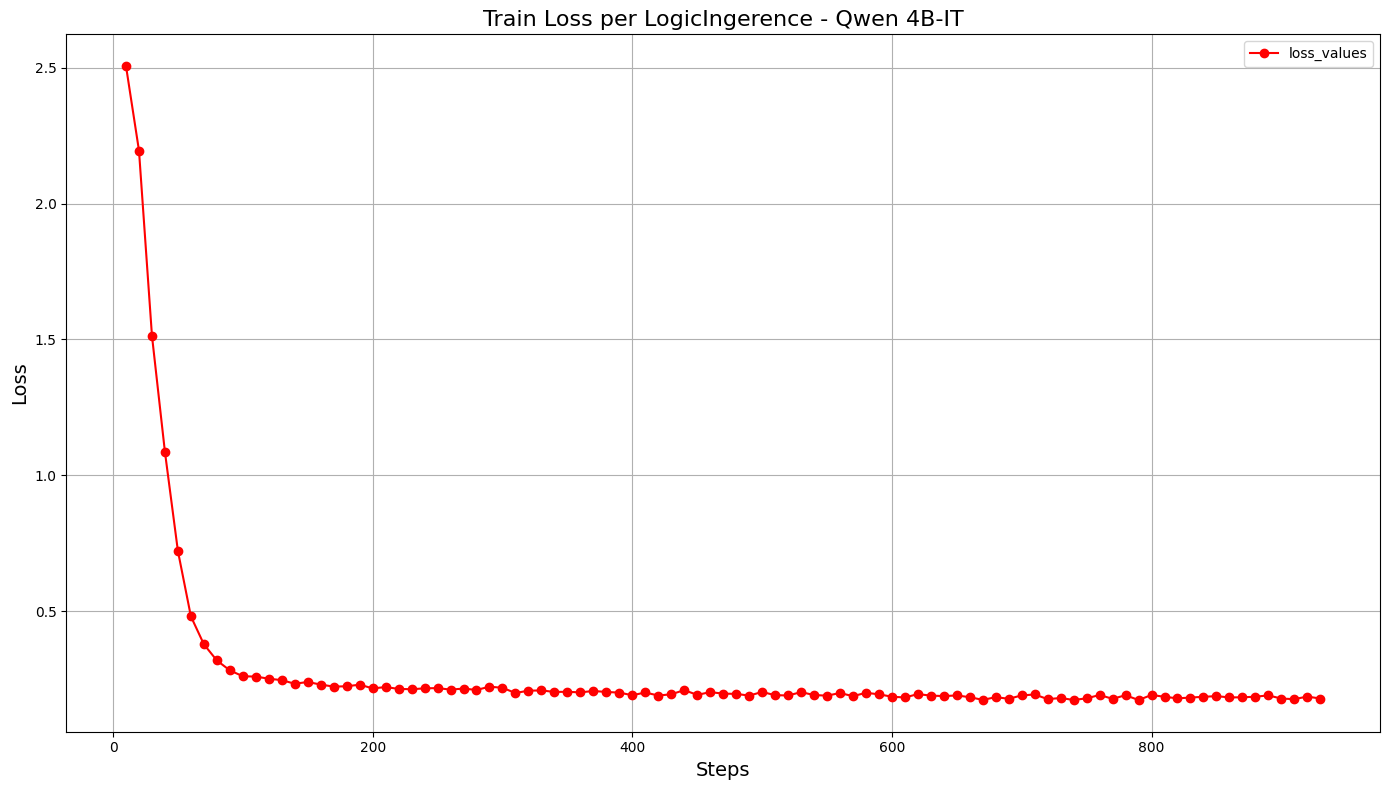

In [31]:
import json
import matplotlib.pyplot as plt

def load_losses(file_name, loss_type):
    with open(file_name, 'r') as f:
        data = json.load(f)
        return data[loss_type] 

losses_LI = load_losses(f"{LOSS_DIR}/losses.json", "train_losses")

losses_LI_steps = list(map(int, losses_LI.keys()))
losses_LI_values = list(losses_LI.values())

plt.figure(figsize=(14, 8))

plt.plot(losses_LI_steps, losses_LI_values, label="loss_values", color="r", marker="o")

plt.title("Train Loss per LogicIngerence - Qwen 4B-IT", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("/kaggle/working/losses_LI_plot.png", dpi=900)
plt.show()

In [32]:
torch.cuda.empty_cache()
gc.collect()

5289